In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

# ==================== HYPERPARAMETERS ====================
hp = {
    'latent_dim': 100,
    'epochs': 1000,
    'batch_size': 64,
    'lr': 2e-4,
    'n_critic': 5,
    'lambda_gp': 10,
    'fm_weight': 0.1,
    'lr_decay': 0.95,
    'min_lr': 1e-6
}

# ==================== DATA PREPARATION ====================
df = pd.read_csv('Diabetes.csv')
X = df.drop(columns=['Diabetes_binary']).values
y = df['Diabetes_binary'].astype(int).values

# Identify classes
class_counts = np.bincount(y)
minority_class = np.argmin(class_counts)
majority_class = np.argmax(class_counts)
samples_needed = class_counts[majority_class] - class_counts[minority_class]

# Extract all minority class data
X_minority = X[y == minority_class]

# Scale using full data fit (consistent transformation)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_minority_scaled = scaler.transform(X_minority)


# ==================== MODEL ARCHITECTURE ====================
def build_generator(latent_dim, output_dim):
    z = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(128)(z)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.Dense(output_dim)(x)
    return tf.keras.Model(z, out)

def build_critic(input_dim):
    inp = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(256)(inp)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    features = tf.keras.layers.Dense(64)(x)
    out = tf.keras.layers.Dense(1)(features)  # Linear output for WGAN
    return tf.keras.Model(inp, [out, features])

# ==================== LOSSES & OPTIMIZATION ====================
def gradient_penalty(critic, real, fake):
    alpha = tf.random.uniform([real.shape[0], 1], 0., 1.)
    interpolated = alpha * real + (1 - alpha) * fake
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred, _ = critic(interpolated)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-10)
    return tf.reduce_mean((norm - 1.0) ** 2)

def feature_matching_loss(fake_logits, real_feats, fake_feats):
    fm = tf.reduce_mean(tf.square(real_feats - fake_feats))
    gen_loss = -tf.reduce_mean(fake_logits)
    return gen_loss + hp['fm_weight'] * fm

# Models & Optimizers
gen = build_generator(hp['latent_dim'], X_train.shape[1])
crit = build_critic(X_train.shape[1])
opt_D = tf.keras.optimizers.Adam(hp['lr'], beta_1=0.5, beta_2=0.9)
opt_G = tf.keras.optimizers.Adam(hp['lr'] * 0.5, beta_1=0.5, beta_2=0.9)

# ==================== TRAINING LOOP ====================
@tf.function
def train_step(minority_batch):
    for _ in range(hp['n_critic']):
        z = tf.random.normal([hp['batch_size'], hp['latent_dim']])
        with tf.GradientTape() as tape_D:
            fake = gen(z, training=True)
            real_logits, _ = crit(minority_batch, training=True)
            fake_logits, _ = crit(fake, training=True)
            gp = gradient_penalty(crit, minority_batch, fake)
            D_loss = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits) + hp['lambda_gp'] * gp
        grads_D = tape_D.gradient(D_loss, crit.trainable_variables)
        opt_D.apply_gradients(zip(grads_D, crit.trainable_variables))

    z = tf.random.normal([hp['batch_size'], hp['latent_dim']])
    with tf.GradientTape() as tape_G:
        fake = gen(z, training=True)
        fake_logits, fake_feats = crit(fake, training=True)
        _, real_feats = crit(minority_batch, training=True)
        G_loss = feature_matching_loss(fake_logits, real_feats, fake_feats)
    grads_G = tape_G.gradient(G_loss, gen.trainable_variables)
    opt_G.apply_gradients(zip(grads_G, gen.trainable_variables))

    return D_loss, G_loss

# Main training loop
for epoch in range(hp['epochs']):
    np.random.shuffle(X_train_minority)
    for i in range(0, X_train_minority.shape[0], hp['batch_size']):
        batch = X_train_minority[i:i + hp['batch_size']]
        if batch.shape[0] < hp['batch_size']:
            continue
        D_loss, G_loss = train_step(tf.convert_to_tensor(batch, dtype=tf.float32))

    if epoch % 200 == 0:
        lr = max(hp['lr'] * (hp['lr_decay'] ** (epoch // 200)), hp['min_lr'])
        opt_D.learning_rate.assign(lr)
        opt_G.learning_rate.assign(lr * 0.5)

    if epoch % 100 == 0:
        z_val = tf.random.normal([1000, hp['latent_dim']])
        synth_val = gen(z_val, training=False).numpy()
        print(f"Epoch {epoch}: D={D_loss:.2f} G={G_loss:.2f} LR={opt_D.learning_rate.numpy():.1e}")

# ==================== SYNTHESIS & EVALUATION & SAVING ====================
z_syn = tf.random.normal([samples_needed, hp['latent_dim']])
synthetic_minority = gen(z_syn, training=False).numpy()

# Inverse scale synthetic samples back to original scale
synthetic_minority_orig = scaler.inverse_transform(synthetic_minority)

# Create DataFrame for synthetic minority samples
df_synthetic_minority = pd.DataFrame(synthetic_minority_orig, columns=df.columns.drop('Diabetes_binary'))
df_synthetic_minority['Diabetes_binary'] = minority_class
df_synthetic_minority['source'] = 'synthetic'

# Prepare real data DataFrame with source column
df_real = df.copy()
df_real['source'] = 'real'

# Combine real and synthetic minority samples

df_balanced = pd.concat([df, df_synthetic_minority], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Save combined dataset
df_balanced.to_csv("WGAN_GP_balanced_diabetes.csv", index=False)

print("\nFinal Statistics:")
print(f"Original shape: {X_train.shape}")
print(f"Synthetic minority samples generated: {synthetic_minority.shape[0]}")
print(f"Balanced dataset shape: {df_balanced.shape}")
print("Class distribution in balanced dataset:")
print(df_balanced['Diabetes_binary'].value_counts())

Epoch 0: D=-1.94 G=-1.53 LR=2.0e-04
Epoch 100: D=-4.34 G=12.43 LR=2.0e-04
Epoch 200: D=-2.25 G=-6.52 LR=1.9e-04
Epoch 300: D=-2.33 G=-33.58 LR=1.9e-04
Epoch 400: D=-3.19 G=-19.55 LR=1.8e-04
Epoch 500: D=-1.55 G=-12.01 LR=1.8e-04
Epoch 600: D=-0.97 G=-11.10 LR=1.7e-04
Epoch 700: D=-6.07 G=-15.28 LR=1.7e-04
Epoch 800: D=-13.61 G=-31.57 LR=1.6e-04
Epoch 900: D=-13.04 G=-80.04 LR=1.6e-04

Final Statistics:
Original shape: (202944, 21)
Synthetic minority samples generated: 182988
Balanced dataset shape: (436668, 23)
Class distribution in balanced dataset:
Diabetes_binary
0.0    218334
1.0    218334
Name: count, dtype: int64


Total data distribution:
source_clear
real         253680
synthetic    182988
Name: count, dtype: int64

Class distribution by source:
Diabetes_binary     0.0     1.0
source_clear                   
real             218334   35346
synthetic             0  182988


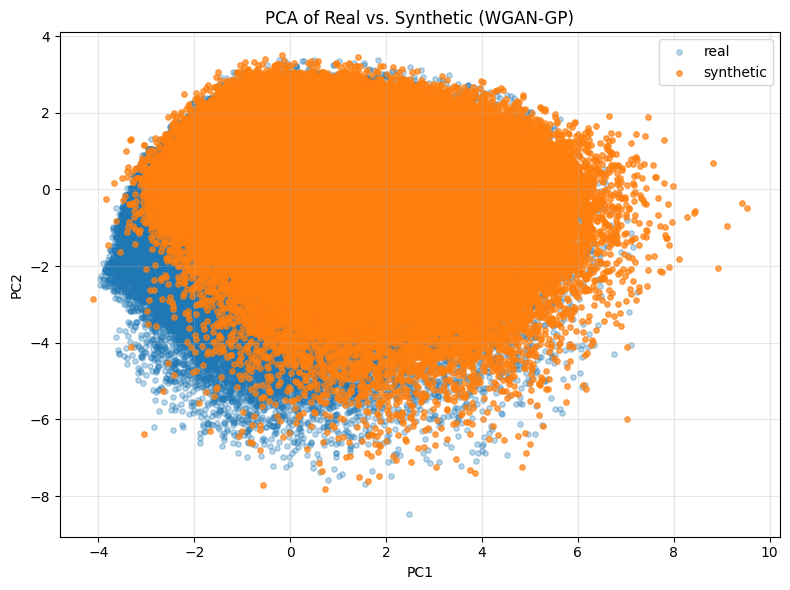

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the balanced dataset
df = pd.read_csv('WGAN_GP_balanced_diabetes.csv')

# Create clear source labels
df['source_clear'] = df['source'].apply(lambda x: 'real' if pd.isna(x) else 'synthetic')

# Separate ALL real vs synthetic data (not just minority)
real_data = df[df['source_clear'] == 'real'].copy()
synthetic_data = df[df['source_clear'] == 'synthetic'].copy()

print("Total data distribution:")
print(df['source_clear'].value_counts())
print("\nClass distribution by source:")
print(pd.crosstab(df['source_clear'], df['Diabetes_binary']))

# For PCA comparison, use ALL data or filter as needed
combined = pd.concat([real_data, synthetic_data], ignore_index=True)

# Get features (exclude target and source columns)
feats = [col for col in combined.columns if col not in ['Diabetes_binary', 'source', 'source_clear']]
X_scaled = StandardScaler().fit_transform(combined[feats])

# PCA
pcs = PCA(n_components=2).fit_transform(X_scaled)
combined['PC1'], combined['PC2'] = pcs[:, 0], pcs[:, 1]

plt.figure(figsize=(8, 6))
for src, alpha in [('real', 0.3), ('synthetic', 0.7)]:
    subset = combined[combined['source_clear'] == src]
    plt.scatter(subset['PC1'], subset['PC2'], alpha=alpha, s=15, 
                label=src)
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Real vs. Synthetic (WGAN-GP)')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


Binary features identified: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

JSD Evaluation of WGAN-GP:

Feature              JSD Score 
------------------------------
HighBP               0.0099    
HighChol             0.0058    
CholCheck            0.0010    
BMI                  0.0962    
Smoker               0.0055    
Stroke               0.0047    
HeartDiseaseorAttack 0.0048    
PhysActivity         0.0008    
Fruits               0.0107    
Veggies              0.0038    
HvyAlcoholConsump    0.0170    
AnyHealthcare        0.0028    
NoDocbcCost          0.0035    
GenHlth              0.6523    
MentHlth             0.3222    
PhysHlth             0.4721    
DiffWalk             0.0035    
Sex                  0.0088    
Age                  0.5225    
Education            0.6297    
Income               0.5973    

Quality Assessment

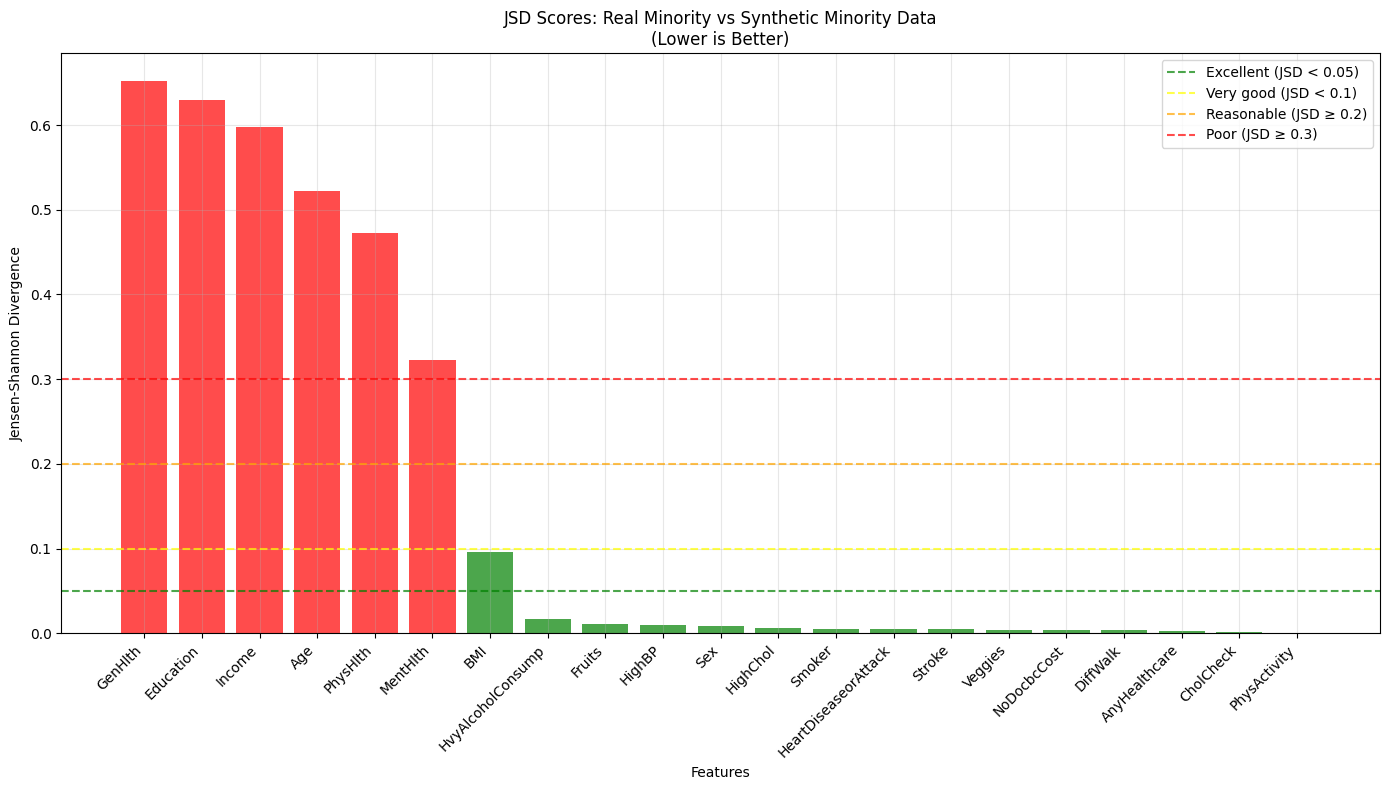


JSD INTERPRETATION GUIDE
0.0 - 0.05: Excellent match (distributions are almost identical)
0.05 - 0.1: Very good match (minor differences)
0.1 - 0.2: Reasonable match (some noticeable differences)
0.2 - 0.3: Noticeable differences (distributions differ)
> 0.3: Significant differences (poor match)


In [15]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt

# 1. CONFIGURATION
TARGET = 'Diabetes_binary'
MINORITY_CLASS = 1.0
DATA_PATH = 'WGAN_GP_balanced_diabetes.csv'
THRESHOLD = 0.5  # For binary conversion

# 2. LOAD DATA
df = pd.read_csv(DATA_PATH)

# 3. THRESHOLD SYNTHETIC DATA
def threshold_synthetic_data(df, threshold=0.5):
    """Convert continuous synthetic outputs to binary for categorical features"""
    binary_features = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if col == TARGET: 
            continue
        unique_vals = df[df['source'].isna()][col].unique()
        if set(unique_vals).issubset({0, 1}) and len(unique_vals) <= 2:
            binary_features.append(col)
    
    print(f"Binary features identified: {binary_features}")
    
    synth_mask = df['source'] == 'synthetic'
    for feature in binary_features:
        df.loc[synth_mask, feature] = (df.loc[synth_mask, feature] > threshold).astype(float)
    
    return df

# APPLY THRESHOLDING
df = threshold_synthetic_data(df)

# 4. JSD CALCULATION FUNCTION
def compute_jsd(p, q, bins=50):
    """Calculate Jensen-Shannon Divergence between two distributions"""
    range_min = min(np.min(p), np.min(q))
    range_max = max(np.max(p), np.max(q))
    p_hist, _ = np.histogram(p, bins=bins, range=(range_min, range_max), density=True)
    q_hist, _ = np.histogram(q, bins=bins, range=(range_min, range_max), density=True)
    p_hist = np.maximum(p_hist, 1e-10)
    q_hist = np.maximum(q_hist, 1e-10)
    p_hist /= p_hist.sum()
    q_hist /= q_hist.sum()
    return distance.jensenshannon(p_hist, q_hist)

# 5. CALCULATE JSD FOR EACH FEATURE
print("\nJSD Evaluation of WGAN-GP:\n")
print("{:<20} {:<10}".format('Feature', 'JSD Score'))
print("-" * 30)

numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET)
jsd_results = []

for col in numeric_cols:
    real_data = df[(df['source'].isna()) & (df[TARGET] == MINORITY_CLASS)][col].values
    synth_data = df[df['source'] == 'synthetic'][col].values
    
    if len(real_data) == 0 or len(synth_data) == 0:
        print(f"{col}: Skipped (no data)")
        continue
        
    jsd = compute_jsd(real_data, synth_data)
    jsd_results.append((col, jsd))
    print("{:<20} {:<10.4f}".format(col, jsd))

# 6. QUALITY ASSESSMENT
jsd_scores = [score for _, score in jsd_results]
total_features = len(jsd_scores)
excellent_match = sum(1 for score in jsd_scores if score < 0.05)
good_match = sum(1 for score in jsd_scores if score < 0.1)

print(f"\nQuality Assessment:")
print(f"Excellent matches (JSD < 0.05): {excellent_match}/{total_features} ({excellent_match/total_features:.1%})")
print(f"Good matches (JSD < 0.1): {good_match}/{total_features} ({good_match/total_features:.1%})")
print(f"Poor matches (JSD >= 0.1): {total_features - good_match}/{total_features} ({(total_features - good_match)/total_features:.1%})")

# 7. VISUALIZATION
plt.figure(figsize=(14, 8))
features, scores = zip(*sorted(jsd_results, key=lambda x: x[1], reverse=True))

colors = [
    'red' if score >= 0.3 else 
    'orange' if score >= 0.2 else 
    'yellow' if score >= 0.1 else 
    'green' 
    for score in scores
]

bars = plt.bar(range(len(features)), scores, color=colors, alpha=0.7)

plt.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Excellent (JSD < 0.05)')
plt.axhline(y=0.1, color='yellow', linestyle='--', alpha=0.7, label='Very good (JSD < 0.1)')
plt.axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='Reasonable (JSD ≥ 0.2)')
plt.axhline(y=0.3, color='red', linestyle='--', alpha=0.7, label='Poor (JSD ≥ 0.3)')

plt.xlabel('Features')
plt.ylabel('Jensen-Shannon Divergence')
plt.title('JSD Scores: Real Minority vs Synthetic Minority Data\n(Lower is Better)')
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. INTERPRETATION GUIDE
print("\n" + "="*60)
print("JSD INTERPRETATION GUIDE")
print("="*60)
print("0.0 - 0.05: Excellent match (distributions are almost identical)")
print("0.05 - 0.1: Very good match (minor differences)")
print("0.1 - 0.2: Reasonable match (some noticeable differences)")
print("0.2 - 0.3: Noticeable differences (distributions differ)")
print("> 0.3: Significant differences (poor match)")